Two Naive Traders
Let's start with a simple coin flip game:

Heads: Win $1
Tails: Lose $1
Probability of heads = 0.5
We'll demonstrate that both the ensemble average (across many players) and time average (one player over time) converge to zero.

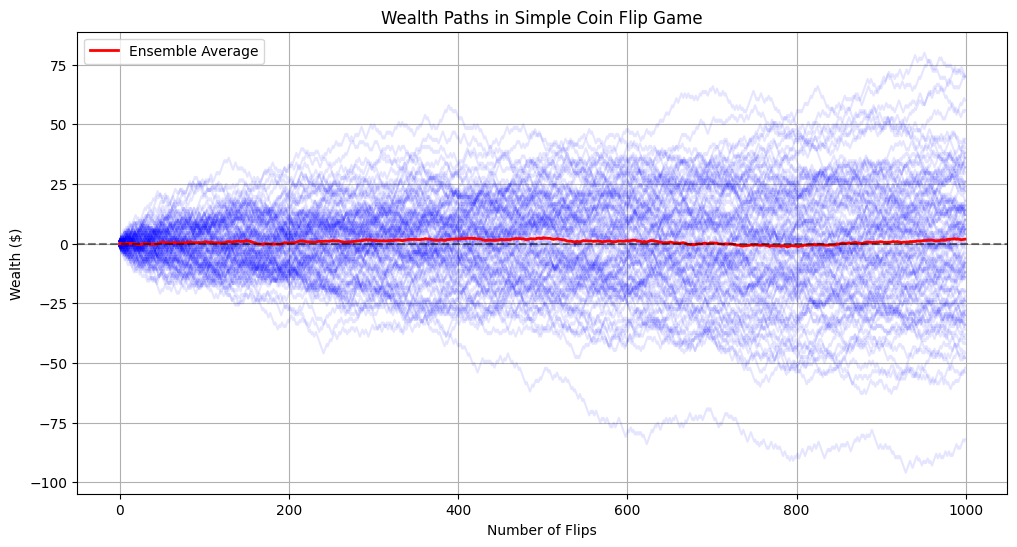

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

def simple_coin_flip_game(n_flips, n_players=1):
    """Simulate basic coin flip game for multiple players."""
    # Generate random flips (1 for heads, 0 for tails)
    flips = np.random.binomial(n=1, p=0.5, size=(n_players, n_flips))
    # Convert to gains/losses (+1 for heads, -1 for tails)
    outcomes = 2 * flips - 1
    # Calculate cumulative wealth
    wealth = np.cumsum(outcomes, axis=1)
    return wealth

# Simulate for multiple players
n_flips = 1000
n_players = 100
wealth_paths = simple_coin_flip_game(n_flips, n_players)

# Plot results
plt.figure(figsize=(12, 6))

# Plot individual paths (semi-transparent)
for i in range(n_players):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot ensemble average
ensemble_avg = np.mean(wealth_paths, axis=0)
plt.plot(ensemble_avg, color='red', linewidth=2, label='Ensemble Average')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Wealth Paths in Simple Coin Flip Game')
plt.xlabel('Number of Flips')
plt.ylabel('Wealth ($)')
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

def simple_coin_flip_game(n_flips, n_players=1):
    """Simulate basic coin flip game for multiple players."""
    # Generate random flips (1 for heads, 0 for tails)
    flips = np.random.binomial(n=1, p=0.5, size=(n_players, n_flips))
    # Convert to gains/losses (+1 for heads, -1 for tails)
    outcomes = 2 * flips - 1
    # Calculate cumulative wealth
    wealth = np.cumsum(outcomes, axis=1)
    return wealth

# Simulate for multiple players
n_flips = 1000
n_players = 100
wealth_paths = simple_coin_flip_game(n_flips, n_players)

# Plot results
plt.figure(figsize=(12, 6))

# Plot individual paths (semi-transparent)
for i in range(n_players):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot ensemble average
ensemble_avg = np.mean(wealth_paths, axis=0)
plt.plot(ensemble_avg, color='red', linewidth=2, label='Ensemble Average')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Wealth Paths in Simple Coin Flip Game')
plt.xlabel('Number of Flips')
plt.ylabel('Wealth ($)')
plt.legend()
plt.grid(True)
plt.show()

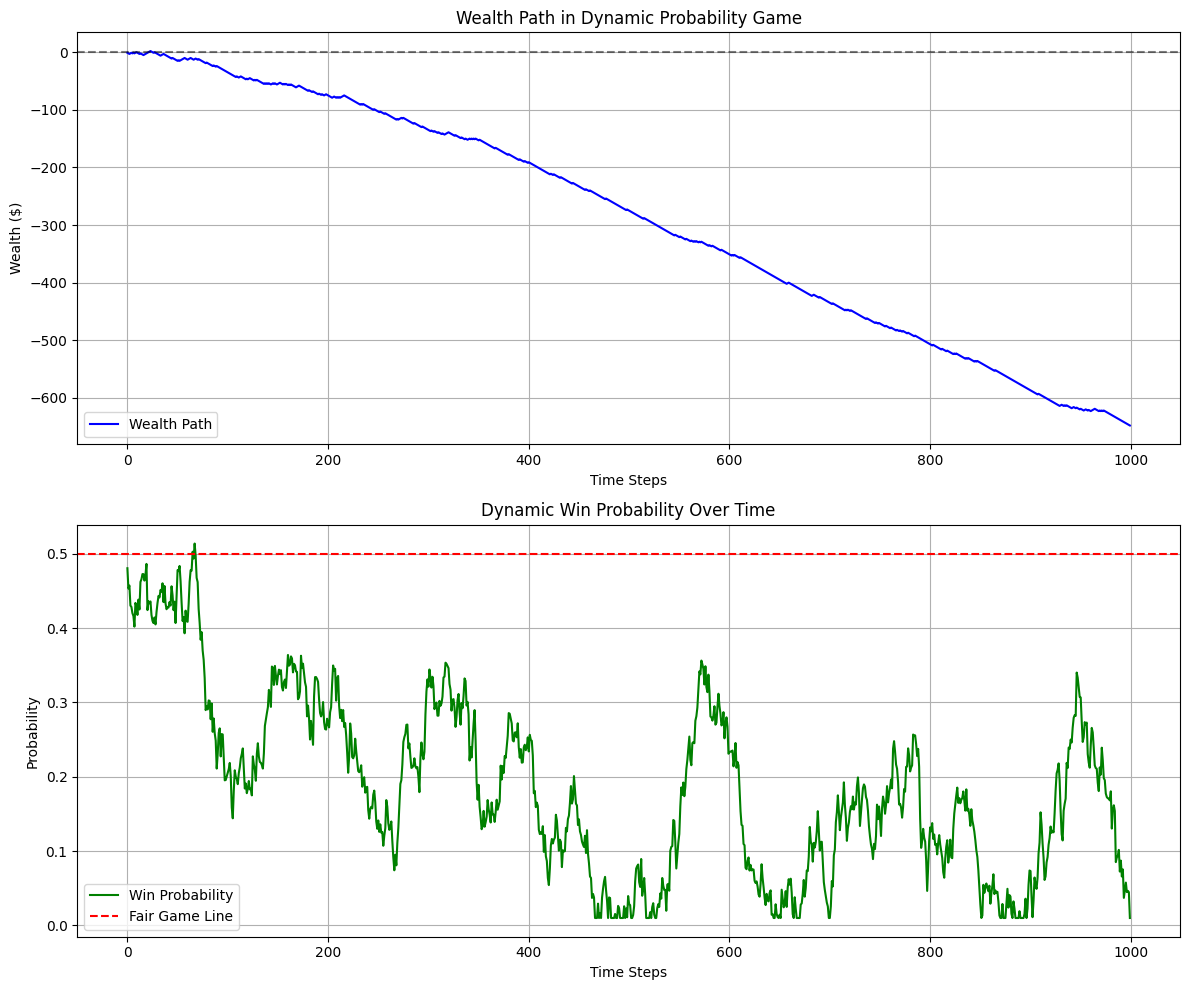

In [4]:
def get_next_change_time(current_time):
    """Determine the next time the probability will change."""
    poisson_time = current_time + np.random.poisson(lam=20)
    geometric_time = current_time + np.random.geometric(p=0.05)
    exponential_time = current_time + np.floor(np.random.exponential(scale=20))
    return int(max(poisson_time, geometric_time, exponential_time))

def dynamic_probability_game(n_steps):
    """Simulate game with dynamically changing probabilities using arithmetic Brownian motion."""
    probabilities = np.zeros(n_steps)
    current_prob = 0.5
    next_change = 0
    
    # Parameters for the stochastic process
    drift = 0.001  # Initial drift
    volatility = 0.02  # Volatility of probability changes
    
    # Generate probability timeline
    for t in range(n_steps):
        if t >= next_change:
            # Randomly change drift direction and magnitude
            drift = np.random.normal(0, 0.002)  # New random drift
            next_change = get_next_change_time(t)
            
        # Update probability using arithmetic Brownian motion
        random_shock = np.random.normal(0, volatility)
        current_prob += drift + random_shock
        
        # Ensure probability stays between 0 and 1
        current_prob = np.clip(current_prob, 0.01, 0.99)
        probabilities[t] = current_prob
    
    # Generate outcomes based on dynamic probabilities
    outcomes = np.random.random(n_steps) < probabilities
    returns = 2 * outcomes - 1  # Convert to +1/-1
    wealth_path = np.cumsum(returns)
    
    return wealth_path, probabilities

# Simulate one game
n_steps = 1000
wealth_path, probabilities = dynamic_probability_game(n_steps)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot wealth path
ax1.plot(wealth_path, color='blue', label='Wealth Path')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Wealth Path in Dynamic Probability Game')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probability changes
ax2.plot(probabilities, color='green', label='Win Probability')
ax2.axhline(y=0.5, color='red', linestyle='--', label='Fair Game Line')
ax2.set_title('Dynamic Win Probability Over Time')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

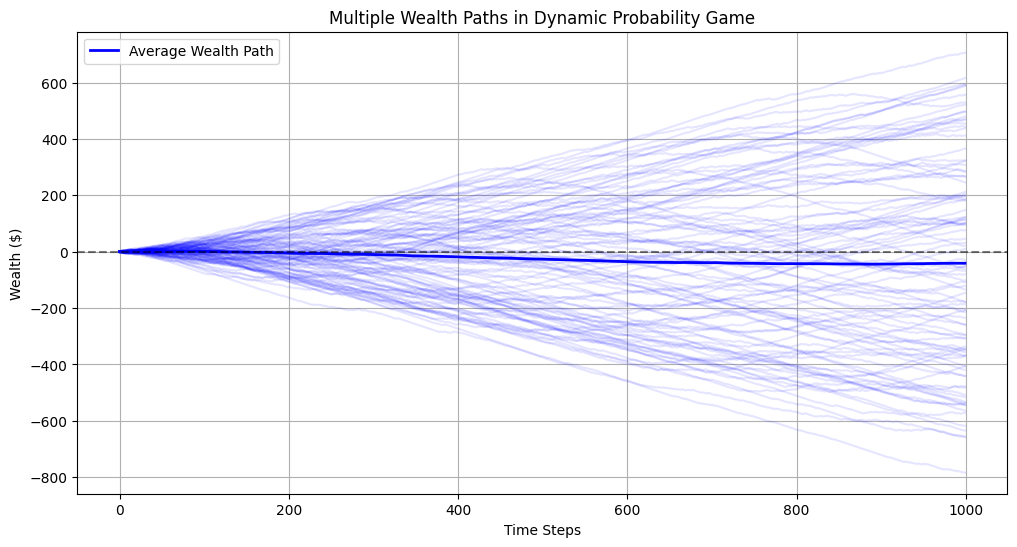

In [5]:
# Run multiple simulations of the dynamic probability game
n_sims = 100
wealth_paths = np.zeros((n_sims, n_steps))
probability_paths = np.zeros((n_sims, n_steps))

for i in range(n_sims):
    w, p = dynamic_probability_game(n_steps)
    wealth_paths[i] = w
    probability_paths[i] = p

# Plot results
plt.figure(figsize=(12, 6))

# Plot individual paths with low opacity
for i in range(n_sims):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot average path with high opacity
plt.plot(np.mean(wealth_paths, axis=0), color='blue', linewidth=2, label='Average Wealth Path')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Multiple Wealth Paths in Dynamic Probability Game')
plt.xlabel('Time Steps')
plt.ylabel('Wealth ($)')
plt.legend()
plt.grid(True)
plt.show()

One Quant Trader, One Naive Trader, a Dynamic Game, Different Models
Now let's implement a strategy that uses recent history (last 30 observations) to estimate the probability and only plays when there appears to be positive expected value compared to the 50/50 pricing.

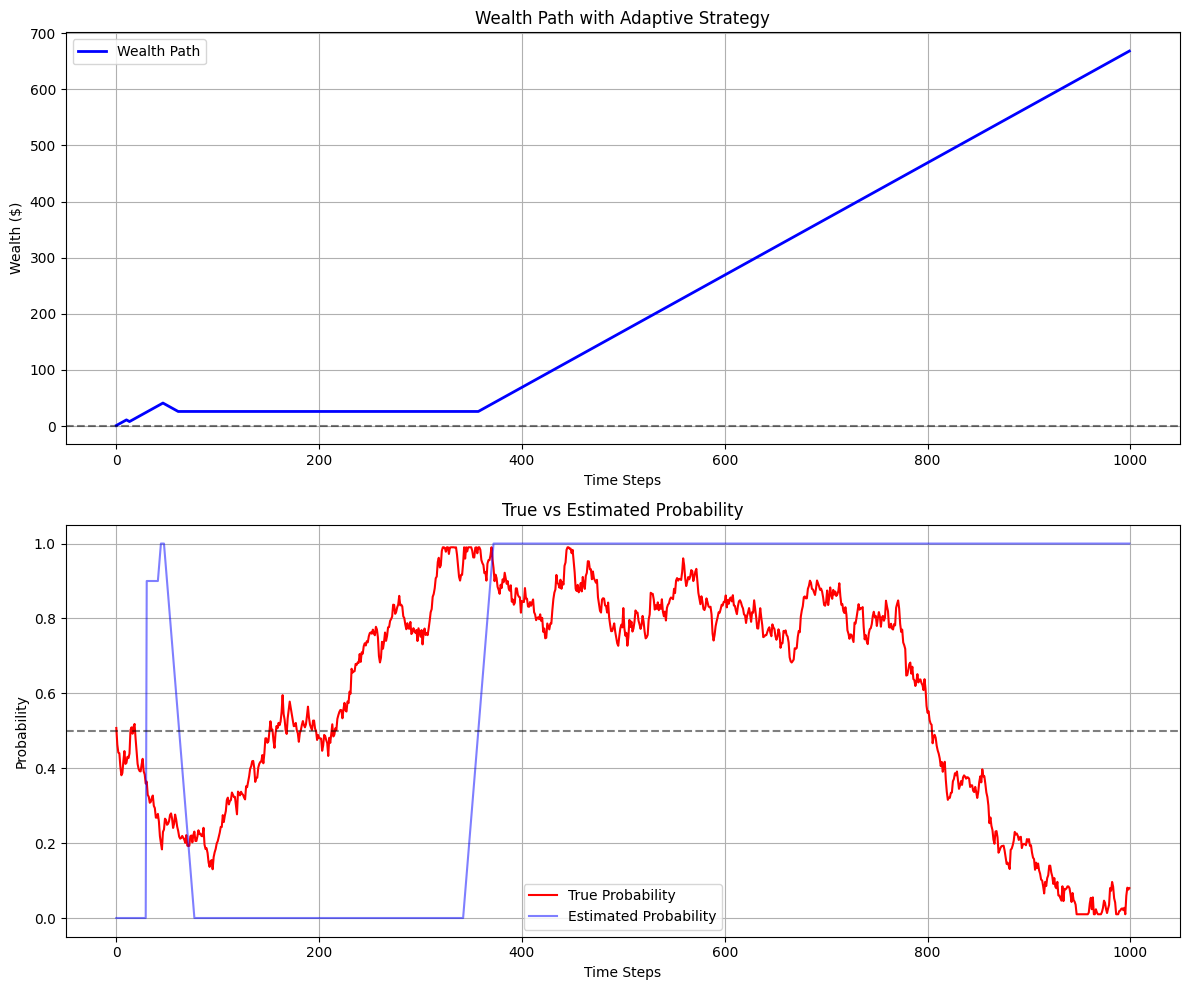

In [6]:
def adaptive_strategy(n_steps, window_size=30):
    """Simulate game with adaptive probability estimation."""
    returns, true_probs = dynamic_probability_game(n_steps)
    
    # Initialize arrays
    wealth = np.zeros(n_steps)
    estimated_probs = np.zeros(n_steps)
    
    # Initial period - just accumulate wealth
    for t in range(window_size):
        wealth[t] = wealth[t-1] + (1 if returns[t] > 0 else -1) if t > 0 else (1 if returns[0] > 0 else -1)
    
    # Main game loop
    for t in range(window_size, n_steps):
        # Convert previous returns to binary outcomes (1 for win, 0 for loss)
        prev_outcomes = (returns[t-window_size:t] > 0).astype(int)
        
        # Estimate probability as ratio of wins to total games
        est_prob = np.mean(prev_outcomes)
        estimated_probs[t] = est_prob
        
        # Only play if estimated probability > 0.5
        if est_prob > 0.5:
            # Add 1 for win, subtract 1 for loss
            wealth[t] = wealth[t-1] + (1 if returns[t] > 0 else -1)
        else:
            wealth[t] = wealth[t-1]  # Don't play
    
    return wealth, estimated_probs, true_probs

# Run single simulation
w, ep, tp = adaptive_strategy(n_steps)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot wealth path
ax1.plot(w, color='blue', linewidth=2, label='Wealth Path')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Wealth Path with Adaptive Strategy')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probabilities
ax2.plot(tp, color='red', label='True Probability')
ax2.plot(ep, color='blue', alpha=0.5, label='Estimated Probability')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Estimated Probability')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

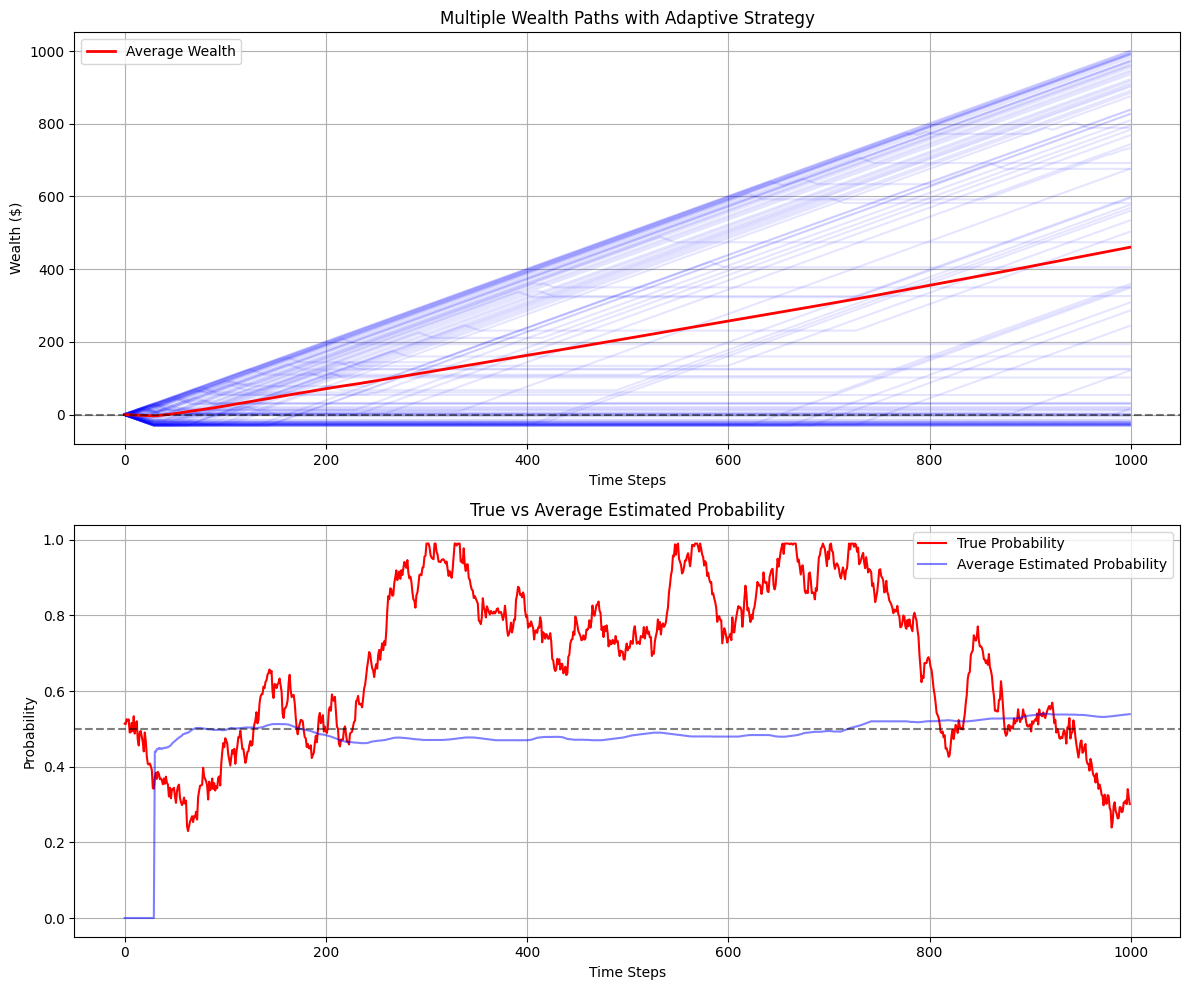

In [7]:
# Run multiple simulations
n_sims = 100
wealth_paths = np.zeros((n_sims, n_steps))
est_prob_paths = np.zeros((n_sims, n_steps))

for i in range(n_sims):
    w, ep, tp = adaptive_strategy(n_steps)
    wealth_paths[i] = w
    est_prob_paths[i] = ep
    if i == 0:
        example_true_probs = tp

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot individual wealth paths
for i in range(n_sims):
    ax1.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot average wealth path
ax1.plot(np.mean(wealth_paths, axis=0), color='red', linewidth=2, label='Average Wealth')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Multiple Wealth Paths with Adaptive Strategy')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probabilities
ax2.plot(example_true_probs, color='red', label='True Probability')
ax2.plot(np.mean(est_prob_paths, axis=0), color='blue', alpha=0.5, label='Average Estimated Probability')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Average Estimated Probability')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Two Quant Traders, a Dynamic Game, Same Models
Finally, let's simulate a game where both players use adaptive strategies. This represents a more realistic market scenario where multiple participants are trying to gain an edge using similar strategies.

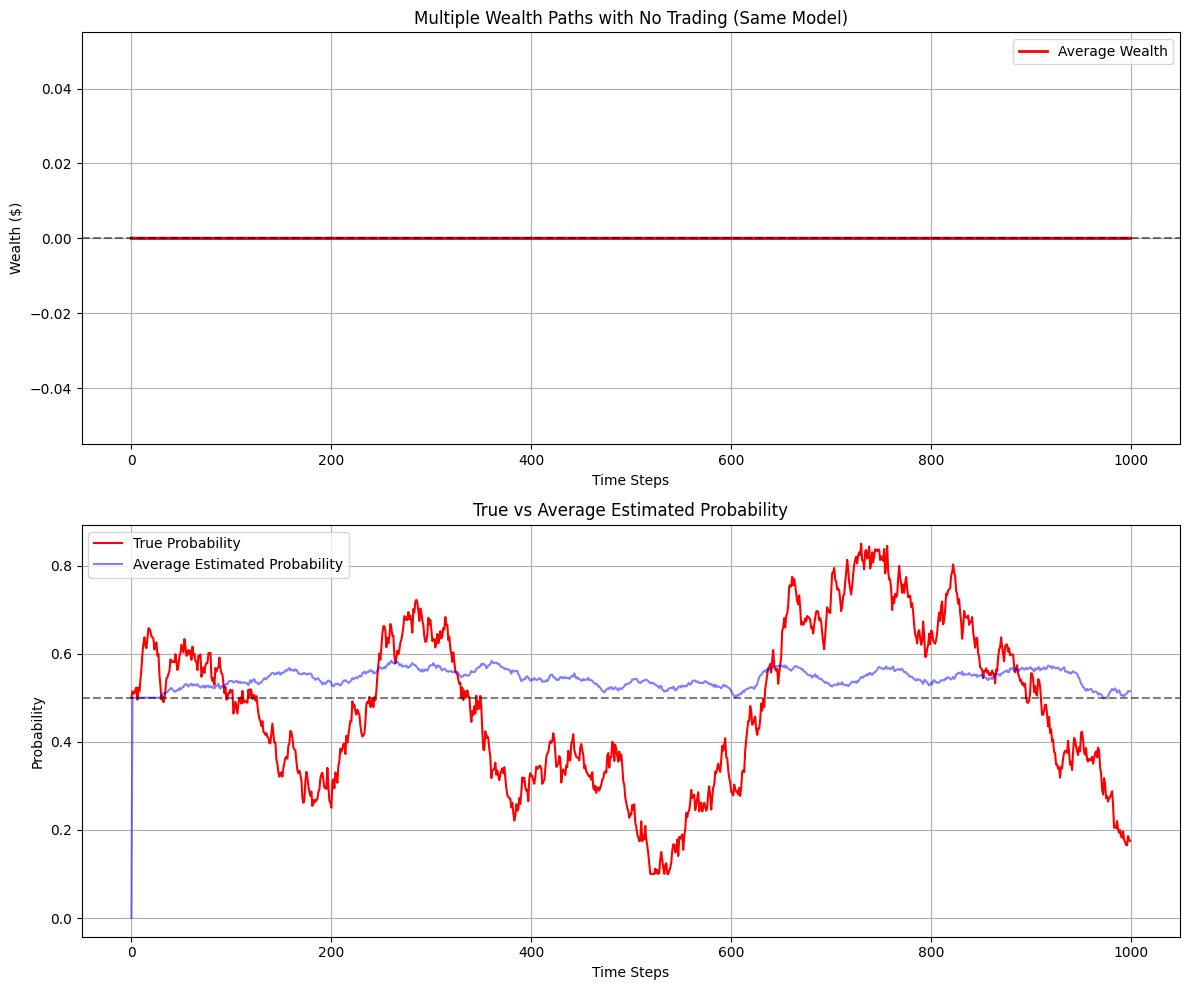

In [8]:
# Parameters
n_steps = 1000
n_sims = 50

# Import deque
from collections import deque

# Initialize arrays to store results
wealth_paths = np.zeros((n_sims, n_steps))
est_prob_paths = np.zeros((n_sims, n_steps))

for i in range(n_sims):
    wealth = np.zeros(n_steps)
    est_prob = np.zeros(n_steps)
    true_prob = np.zeros(n_steps)
    
    # Initial probability estimate
    p_est = 0.5
    window_size = 30
    recent_outcomes = deque(maxlen=window_size)
    
    # Generate true probability path
    true_prob[0] = 0.5
    for t in range(1, n_steps):
        # Random walk for true probability
        true_prob[t] = true_prob[t-1] + np.random.normal(0, 0.02)
        true_prob[t] = min(max(true_prob[t], 0.1), 0.9)  # Keep within bounds
        
        # Generate outcome
        outcome = np.random.random() < true_prob[t]
        recent_outcomes.append(outcome)
        
        # Update probability estimate
        if len(recent_outcomes) >= window_size:
            p_est = sum(recent_outcomes) / window_size
        
        # Store probability estimate
        est_prob[t] = p_est
        
        # No trading occurs since both parties use same model
        wealth[t] = wealth[t-1]  # Wealth stays flat
    
    wealth_paths[i] = wealth
    est_prob_paths[i] = est_prob
    if i == 0:
        example_true_probs = true_prob

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot individual wealth paths
for i in range(n_sims):
    ax1.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot average wealth path
ax1.plot(np.mean(wealth_paths, axis=0), color='red', linewidth=2, label='Average Wealth')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Multiple Wealth Paths with No Trading (Same Model)')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probabilities
ax2.plot(example_true_probs, color='red', label='True Probability')
ax2.plot(np.mean(est_prob_paths, axis=0), color='blue', alpha=0.5, label='Average Estimated Probability')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Average Estimated Probability')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Two Quant Traders, a Dynamic Game, Different Models

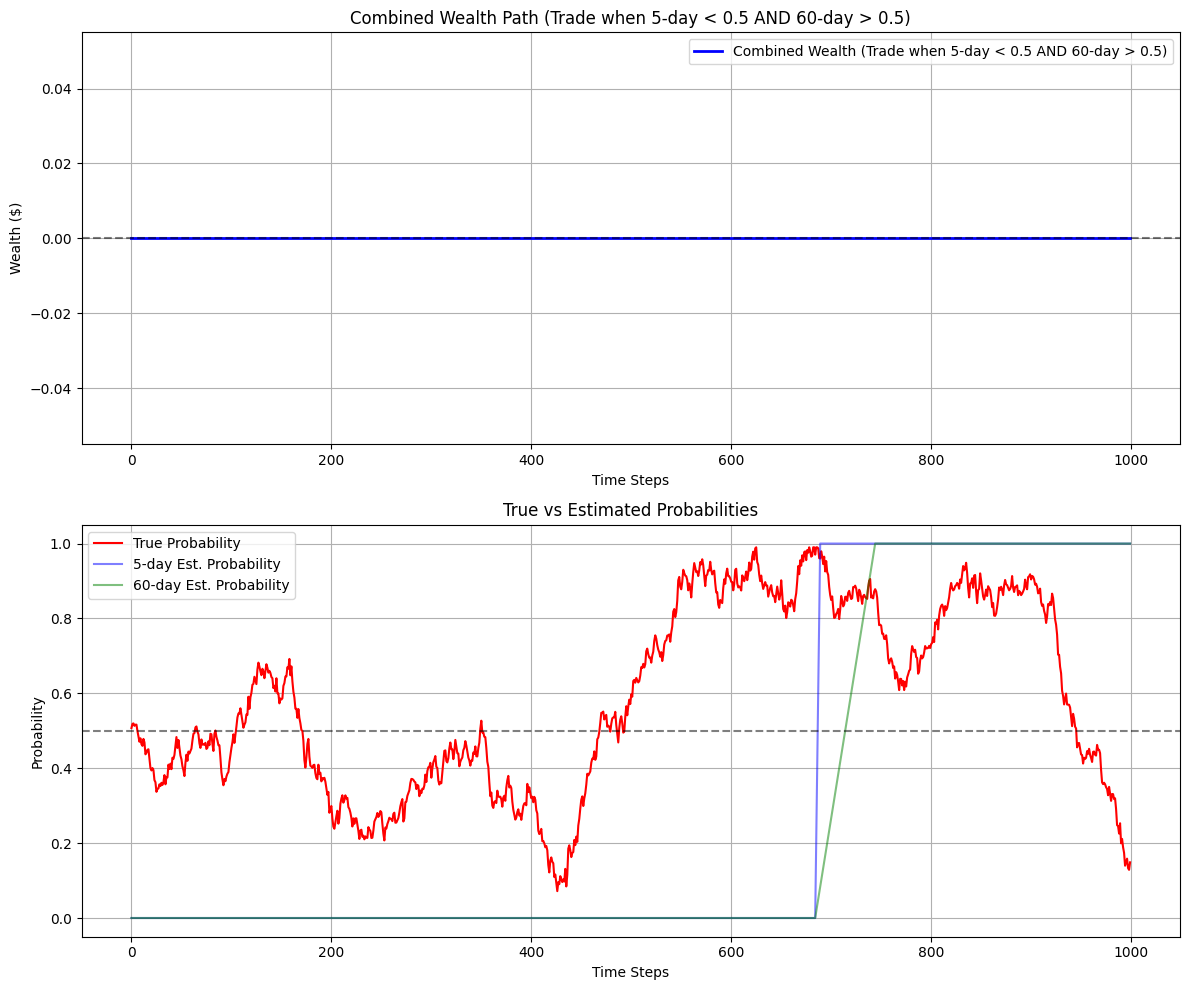

In [9]:
def adaptive_strategy_two_players(n_steps, window_1=5, window_2=60):
    """Simulate game with two players using different window sizes."""
    returns, true_probs = dynamic_probability_game(n_steps)
    
    # Initialize arrays
    wealth = np.zeros(n_steps)
    est_probs_1 = np.zeros(n_steps)  # 15-day window estimates
    est_probs_2 = np.zeros(n_steps)  # 30-day window estimates
    
    # Initial period - no trading until we have enough data for both windows
    max_window = max(window_1, window_2)
    for t in range(max_window):
        wealth[t] = wealth[t-1] if t > 0 else 0
    
    # Main game loop
    for t in range(max_window, n_steps):
        # Calculate probabilities for both windows
        prev_outcomes_1 = (returns[t-window_1:t] > 0).astype(int)
        prev_outcomes_2 = (returns[t-window_2:t] > 0).astype(int)
        
        est_prob_1 = np.mean(prev_outcomes_1)  # 15-day estimate
        est_prob_2 = np.mean(prev_outcomes_2)  # 30-day estimate
        
        est_probs_1[t] = est_prob_1
        est_probs_2[t] = est_prob_2
        
        # Player 1 wants to play if 15-day prob < 0.5
        # Player 2 wants to play if 30-day prob > 0.5
        # Only trade if both conditions are met
        if est_prob_1 < 0.5 and est_prob_2 > 0.5:
            wealth[t] = wealth[t-1] + (1 if returns[t] > 0 else -1)
        else:
            wealth[t] = wealth[t-1]  # No trade
    
    return wealth, est_probs_1, est_probs_2, true_probs

# Run single simulation
w, ep1, ep2, tp = adaptive_strategy_two_players(n_steps)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot wealth path
ax1.plot(w, color='blue', linewidth=2, label='Combined Wealth (Trade when 5-day < 0.5 AND 60-day > 0.5)')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Combined Wealth Path (Trade when 5-day < 0.5 AND 60-day > 0.5)')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probabilities
ax2.plot(tp, color='red', label='True Probability')
ax2.plot(ep1, color='blue', alpha=0.5, label='5-day Est. Probability')
ax2.plot(ep2, color='green', alpha=0.5, label='60-day Est. Probability')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Estimated Probabilities')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Conclusions
This notebook demonstrates several key insights about trading and modeling:

In a simple, stationary game (coin flip), both time and ensemble averages converge to the true expected value.

When the underlying probabilities change dynamically, simple static models (like assuming 50/50) become ineffective.

Adaptive strategies that use recent historical data can potentially capture some edge, but they're not perfect:

They lag behind true probability changes
They can be fooled by random sequences
They require careful parameter tuning (window size, thresholds)
When multiple players use similar strategies, the advantage can diminish as they compete for the same opportunities.

This illustrates the famous quote by statistician George Box: "All models are wrong, but some are useful." The key to successful trading isn't finding a perfect model (which doesn't exist), but rather finding models that are useful enough to provide an edge while understanding their limitations.